In [ ]:
%%capture

# Install the required libraries.
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
# required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar

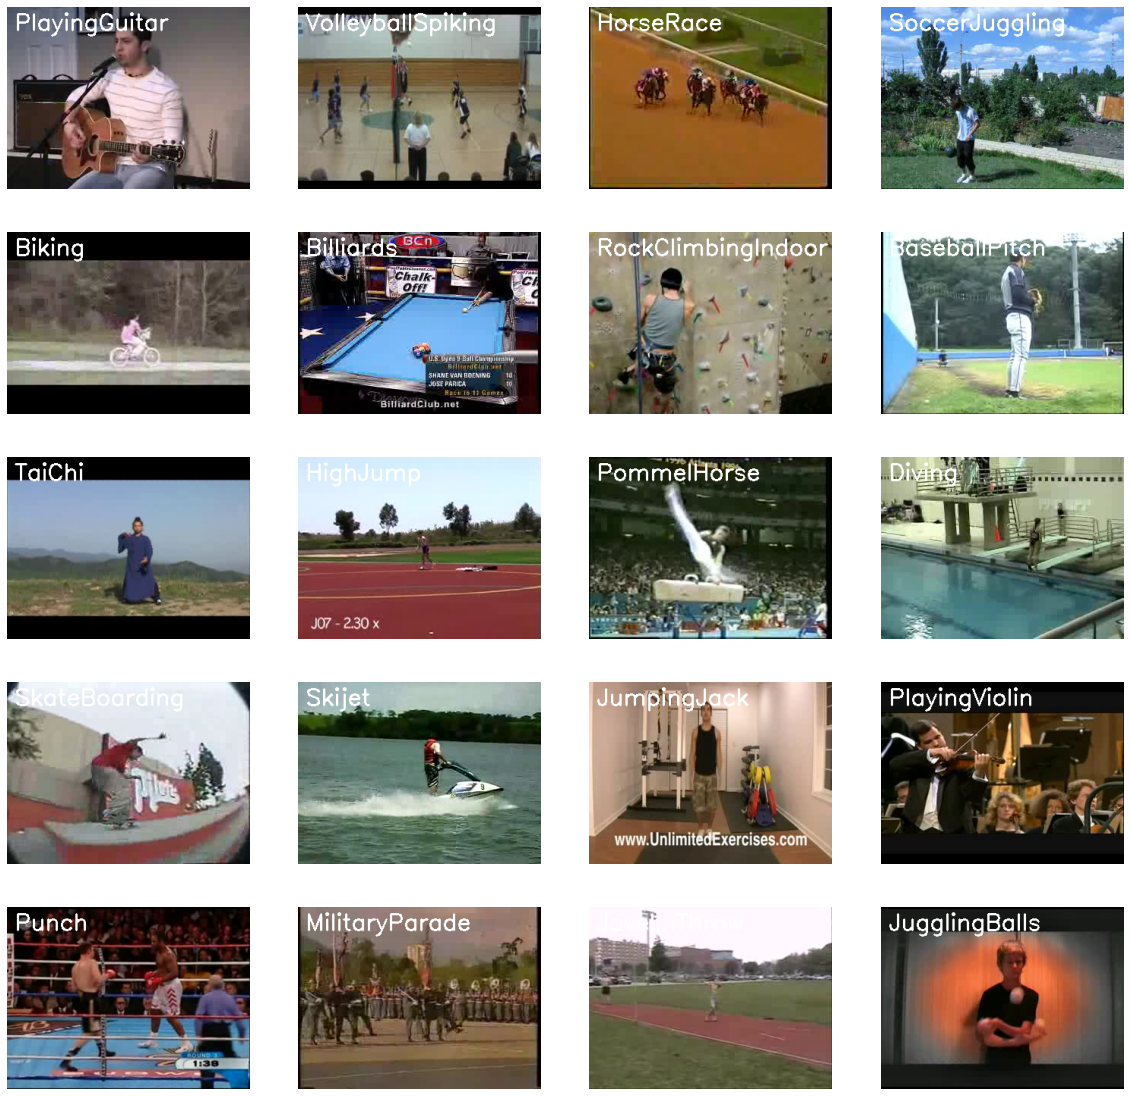

In [ ]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()

    # Convert the frame from BGR into RGB format since mtplotlib works on RGB 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [ ]:
# height and width to which each video frame will be resized in our dataset.
Img_hgt , Img_wt = 64, 64

# number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20
 
DATASET_DIR = "UCF50"

# classes used for training.
CLASSES_LIST = ["TaiChi", "Swing","Basketball","Biking","Drumming","HighJump","HorseRace","Nunchucks","PlayingGuitar","WalkingWithDog"]

In [ ]:
# function to extract frames from a video
def frames_extraction(video_path):

    # list to store video frames.
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    # total number of frames in the video
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 

        if not success:
            break

        # Resizing the frames 
        resized_frame = cv2.resize(frame, (Img_hgt, Img_wt))
        
        # Normalize the resized frames
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
    
    video_reader.release()

    return frames_list

In [ ]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
      
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [ ]:
# Creating the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: Basketball
Extracting Data of Class: Biking
Extracting Data of Class: Drumming
Extracting Data of Class: HighJump
Extracting Data of Class: HorseRace
Extracting Data of Class: Nunchucks
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: WalkingWithDog


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Spliting the data into train(75%) and test set(25%).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [ ]:
def create_LRCN_model():

    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(50))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    
    return model

In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

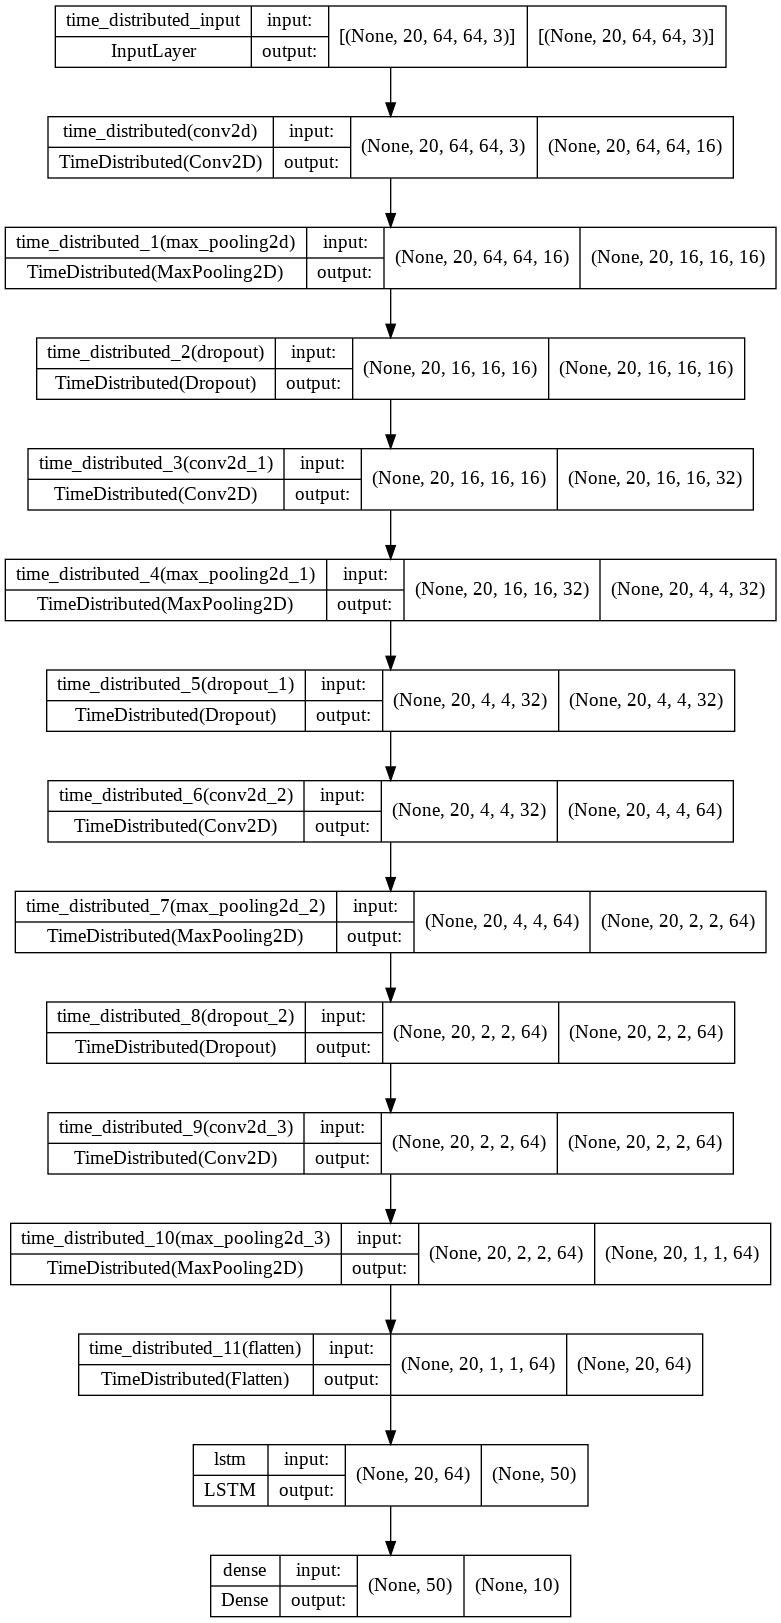

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 60, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.1)

Epoch 1/60
230/230 [==============================] - 40s 163ms/step - loss: 2.2961 - accuracy: 0.1404 - val_loss: 2.2855 - val_accuracy: 0.1456
Epoch 2/60
230/230 [==============================] - 36s 156ms/step - loss: 2.1626 - accuracy: 0.1730 - val_loss: 2.0527 - val_accuracy: 0.1262
Epoch 3/60
230/230 [==============================] - 36s 156ms/step - loss: 1.9592 - accuracy: 0.2699 - val_loss: 1.8872 - val_accuracy: 0.2136
Epoch 4/60
230/230 [==============================] - 36s 157ms/step - loss: 1.7328 - accuracy: 0.3689 - val_loss: 1.5511 - val_accuracy: 0.4369
Epoch 5/60
230/230 [==============================] - 36s 157ms/step - loss: 1.4831 - accuracy: 0.4581 - val_loss: 1.4061 - val_accuracy: 0.5437
Epoch 6/60
230/230 [==============================] - 36s 157ms/step - loss: 1.2151 - accuracy: 0.5680 - val_loss: 1.5931 - val_accuracy: 0.4951
Epoch 7/60
230/230 [==============================] - 36s 157ms/step - loss: 1.1409 - accuracy: 0.5952 - val_loss: 1.8655 - val_ac

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)      

11/11 [==============================] - 4s 360ms/step - loss: 0.9099 - accuracy: 0.8416


In [ ]:
model_file_name = f'model.h5'

# Save the Model.
LRCN_model.save(model_file_name)

In [1]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

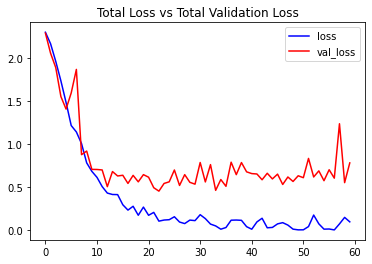

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

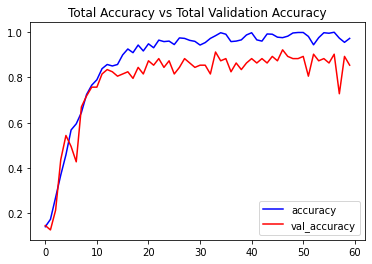

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
def download_youtube_videos(youtube_video_url, output_directory):
     
     video = pafy.new(youtube_video_url)
     title = video.title
     video_best = video.getbest()
     output_file_path = f'{output_directory}/{title}.mp4'

     video_best.download(filepath = output_file_path, quiet = True)

     return title

In [ ]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():

        ok, frame = video_reader.read() 

        if not ok:
            break

        resized_frame = cv2.resize(frame, (Img_hgt, Img_wt))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)
        
    video_reader.release()
    video_writer.release()

In [ ]:
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

100%|██████████| 867/867 [00:02<00:00, 314.45it/s]
